<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#A-Machine-Learning-Perspective-on-Regression" data-toc-modified-id="A-Machine-Learning-Perspective-on-Regression-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>A Machine-Learning Perspective on Regression</a></span></li><li><span><a href="#Non-Parametric-Models" data-toc-modified-id="Non-Parametric-Models-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Non-Parametric Models</a></span><ul class="toc-item"><li><span><a href="#Parametric-vs.-Non-Parametric-Models" data-toc-modified-id="Parametric-vs.-Non-Parametric-Models-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Parametric vs. Non-Parametric Models</a></span></li><li><span><a href="#Linear-Interpolation" data-toc-modified-id="Linear-Interpolation-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Linear Interpolation</a></span></li><li><span><a href="#Exercise:-Use-every-third-data-point-of-the-spectra-dataset-to-train-a-linear-interpolation-model" data-toc-modified-id="Exercise:-Use-every-third-data-point-of-the-spectra-dataset-to-train-a-linear-interpolation-model-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Exercise: Use every third data point of the spectra dataset to train a linear interpolation model</a></span></li></ul></li><li><span><a href="#Kernel-Regression" data-toc-modified-id="Kernel-Regression-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Kernel Regression</a></span><ul class="toc-item"><li><span><a href="#Exercise:-Evaluate-the-performance-of-the-rbf-kernel-as-a-function-of-kernel-width" data-toc-modified-id="Exercise:-Evaluate-the-performance-of-the-rbf-kernel-as-a-function-of-kernel-width-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Exercise: Evaluate the performance of the rbf kernel as a function of kernel width</a></span></li></ul></li></ul></div>

# Non-Parametric Models

## A Machine-Learning Perspective on Regression

The goal of regression is to find a function

$\vec{y} = f(\vec{x}) + \vec{\epsilon}$

where $f$ is the model, $x$ is the model input, $y$ is the model output, and $\epsilon$ is the error between the model in the data. The model inputs, $\vec{x}$ are often called the **features** of a data point. In the previous example we created features using transformations of $x$ like polynomials and Gaussian functions. Sometimes, features may also be given in the dataset (e.g. multiple inputs correspond to a single output). Other times, the model input may be data that does not have obvious vector-based features (e.g. images, audio, molecules, etc.). In this case, we can think of the features as "fingerprints" of some more complex raw input data.

Of course representing the model as $f$ is a gross oversimplification. The function must have some form, and it usually requires **parameters**. Previously we considered general linear regression models of the form:

$y_i = \sum_j w_j X_{ij} + \epsilon_i$

where the **parameters** are given by $\vec{w}$. We also considered non-linear regression with Gaussian functions, which required more parameters, $\vec{w}$, $\vec{\mu}$, and $\vec{\sigma}$. We saw that in order to optimize these parameters we had to put them into a single vector. We could consider this to be a parameter vector, $\vec{\lambda} = [\vec{w}, \vec{\mu}, \vec{\sigma}]$, and re-write the model more generally as:

$\vec{y} = f(\vec{x}, \vec{\lambda}) + \vec{\epsilon}$

We also had to decide on how many parameters to include. In the case of polynomial regression this corresponded to the order of the highest polynomial, while for Gaussian regression it corresponded to the number of Gaussian functions to include. This number of parameters to include is called a **hyperparameter**. Hyperparameters control the complexity of the final model, and the parameters will depend on the hyperparameters, so we can think of the parameters as being a function of the hyperparameters, $\vec{\lambda}(\vec{\eta})$. If we put all this together we get a model form of:

$\vec{y} = f(\vec{x}, \vec{\lambda}(\vec{\eta})) + \vec{\epsilon}$

Machine learning differs from regular regression in that it seeks to optimize $\vec{\lambda}$ (parameter optimization), $\vec{\eta}$ (complexity optimization) in order to **obtain a model that generalizes to new input data**. Machine learning also sometimes involves selecting $\vec{x}$ (feature selection) or generating $\vec{x}$ from non-vectorized data such as text or images (feature generation).

## Non-Parametric Models

We covered the basic math behind parameter optimization in the numerical methods module. The basic idea is to follow two steps:

* Construct a loss function that quantifies how well your model fits the data
* Minimize the loss function with respect to the model parameters

The loss function itself could be the sum of squared errors, some other measure of error (e.g. absolute value of error), and can also contain constraints on the parameters themselves (e.g. force parameters to be positive).

Minimizing the loss function can be achieved analytically in the case of general linear models, or numerically for non-linear models. Moving forward we will typically default to numerical optimization.

In this section we will explore another aspect of model parameters by looking at a new class of models called "non-parameteric" models. The math of parameter optimization is the same, but the way the parameters are defined is different.

### Parametric vs. Non-Parametric Models

A "parametric" model has parameters that do not explicitly depend on or include the input points. The polynomial regression model is an example of a parametric model. The number of parameters is fixed with respect to the number of data points.

A "non-parametric" model includes parameters that are defined on the domain of the independent variables and depend on the inputs. A spline model is an example of a non-parametric model. The number of parameters in the model varies with the number of data points.

Nonparametric models are generally excellent for interpolation, but fail miserably for extrapolation, while parametric models are less accurate for interpolation but provide more reasonable extrapolations. Nonparametric models tend to have many more parameters, and proper optimization of model complexity can lead to similar performance for both types.

See [this post](https://machinelearningmastery.com/parametric-and-nonparametric-machine-learning-algorithms/) for more information.

### Linear Interpolation

Let's revisit the spectra dataset that we worked with during the last module:

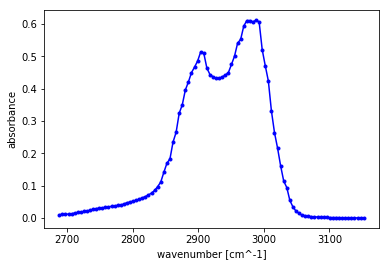

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('data/ethanol_IR.csv')
x_all = df['wavenumber [cm^-1]'].values
y_all = df['absorbance'].values

x_peak = x_all[475:575]
y_peak = y_all[475:575]

fig, ax = plt.subplots()
ax.plot(x_peak,y_peak, '-b', marker='.')
ax.set_xlabel('wavenumber [cm^-1]')
ax.set_ylabel('absorbance');

Let's consider the common problem that we want to interpolate between points with a straight line. It turns out we can solve this by using a general linear model!

The key is to use a basis of "piecewise linear" functions:

$X_{ij} = max(0, x_i-x_j)$

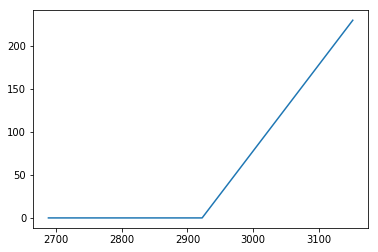

In [2]:
def piecewise_linear(x):
    N = len(x)
    X = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            X[i,j] = max(0, x[i] - x[j])
    return X
            
X = piecewise_linear(x_peak)

fig, ax = plt.subplots()
ax.plot(x_peak, X[:,50]);

Let's take a look at all of the basis functions:

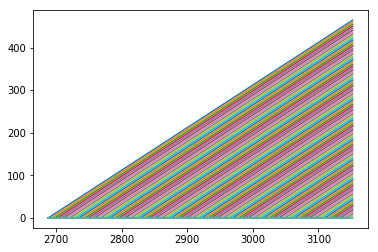

In [3]:
fig, ax = plt.subplots()
for i in range(len(x_peak)):
    ax.plot(x_peak, X[:,i]);

Our basis set, or "features" consist straight lines with slope 1 that originate at each data point. Now we can achieve linear interpolation by solving the general linear regression problem. We will use `scikit-learn` to make this easy, but you can verify the solution using the equations from the foundations module if you want:

r^2 = 1.0


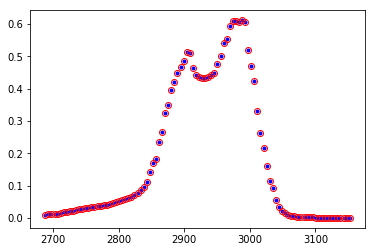

In [4]:
from sklearn.linear_model import LinearRegression

model = LinearRegression() #create a linear regression model instance
model.fit(X, y_peak) #fit the model
r2 = model.score(X, y_peak) #get the "score", which is equivalent to r^2

yhat = model.predict(X) #create the model prediction

fig, ax = plt.subplots()
ax.plot(x_peak, y_peak, '.b')
ax.plot(x_peak, yhat, 'or', markerfacecolor='none')
print('r^2 = {}'.format(r2))

We can see that the model goes through every point exactly, which we should know from $r^2=1$. However, we don't actually know what the model is doing in between the points. For this we need to predict on a new set of $x$ points that has a higher resolution:

In [5]:
x_predict = np.linspace(2650, 3150, 500)
X_predict = piecewise_linear(x_predict)

#yhat_pred = model.predict(X_predict)

We see that we cannot predict on the new dataset because the dimensions of the matrices do not match. The column space acts as a basis set for regression, and when we trained the model we had 100 "features" (one for each data point). However, our new X matrix has 500 columns, which is a different set of features than the 100 that we trained on originally. If we want to make predictions we need to expand the **row** space while keeping the column space constant.

r^2 = 1.0


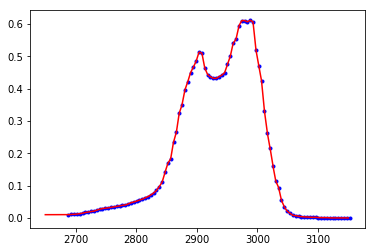

In [6]:
def piecewise_linear(x_train, x_test=None):
    if x_test is None:
        x_test = x_train
    N = len(x_test) #<- number of data points
    M = len(x_train) #<- number of features
    X = np.zeros((N,M))
    for i in range(N):
        for j in range(M):
            X[i,j] = max(0, x_test[i] - x_train[j])
    return X

X_predict = piecewise_linear(x_peak, x_predict)

yhat_predict = model.predict(X_predict)

fig, ax = plt.subplots()
ax.plot(x_peak, y_peak, '.b')
ax.plot(x_predict, yhat_predict, '-r', markerfacecolor='none')
print('r^2 = {}'.format(r2))

We see that the model successful at interpolating between the points. This is an example of a **non-parametric** model. The number of parameters, $\vec{w}$ is equal to the number of data points.

### Exercise: Use every third data point of the spectra dataset to train a linear interpolation model

First, select every third datapoint from the `(x_peak, y_peak)` dataset, and use this to train a linear interpolation model. Then, predict the full dataset using the model.

## Kernel Regression

We are not limited to using piecewise linear functions. We can actually generalize this using the idea of a "kernel":

$K(i, j) = f(x_i, x_j)$

where $f$ can be any function. The most commonly used kernel is the "radial basis function", or `rbf` kernel:

$rbf(i, j) = exp(-\gamma (x_i - x_j)^2)$

If you look closely, you will see that this is the same as a Gaussian function, where $\mu = x_j$ and $\gamma = \frac{1}{2\sigma^2}$:

$G(x_i) = exp\left(\frac{-(x_i - \mu)^2}{2\sigma^2}\right)$

Let's follow the same procedure as before, but now we will use a "radial basis function":

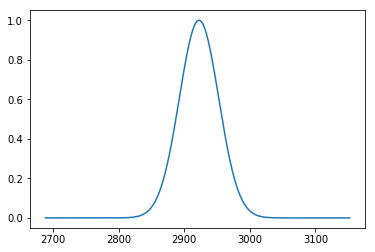

In [7]:
def rbf(x_train, x_test=None, gamma=1):
    if x_test is None:
        x_test = x_train
    N = len(x_test) #<- number of data points
    M = len(x_train) #<- number of features
    X = np.zeros((N,M))
    for i in range(N):
        for j in range(M):
            X[i,j] = np.exp(-gamma*(x_test[i] - x_train[j])**2)
    return X

sigma = 30
gamma = 1./(2*sigma**2)
x_test = np.linspace(min(x_peak), max(x_peak), 300)
X_rbf = rbf(x_peak, x_test=x_test, gamma=gamma)

fig, ax = plt.subplots()
ax.plot(x_test, X_rbf[:,50]);

Essentially, we are now putting a Gaussian basis set with a fixed width at every training point! Let's see how it performs:

r^2 = 0.9994115530941873


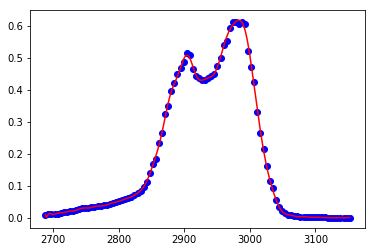

In [8]:
X_train = rbf(x_peak, gamma=gamma)

model_rbf = LinearRegression() #create a linear regression model instance
model_rbf.fit(X_train, y_peak) #fit the model
r2 = model_rbf.score(X_train, y_peak) #get the "score", which is equivalent to r^2
print('r^2 = {}'.format(r2))

X_test = rbf(x_peak, x_test=x_test, gamma=gamma)

yhat_rbf = model_rbf.predict(X_test) #create the model prediction

fig, ax = plt.subplots()
ax.plot(x_peak, y_peak, 'ob')
ax.plot(x_test, yhat_rbf, '-r', markerfacecolor='none');

### Exercise: Evaluate the performance of the rbf kernel as a function of kernel width

Use the same strategy as the previous exercise to select every third point in the spectra to use as the training set. Then, vary the width of the radial basis function with $\sigma = [1, 10, 100]$, and compute the $r^2$ score for each *using the entire dataset*.

Plot $r^2$ as a function of $\sigma$.

In [9]:
sigmas = [1, 10, 100]
#insert code here

Let's also see how the performance of the model changes as we use fewer initial training points:

r^2 training = 1.0
r^2 testing = 0.9984890582179191


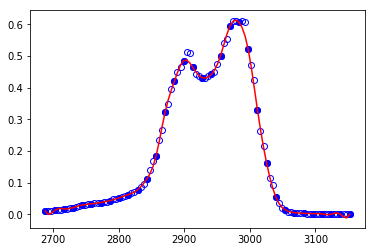

In [20]:
spacing = 3
sigma = 10
gamma = 1./(2*sigma**2)

x_train = x_peak[::spacing]
y_train = y_peak[::spacing]

X_train = rbf(x_train, gamma=gamma)

model_rbf = LinearRegression() #create a linear regression model instance
model_rbf.fit(X_train, y_train) #fit the model
r2 = model_rbf.score(X_train, y_train) #get the "score", which is equivalent to r^2
print('r^2 training = {}'.format(r2))

X_all = rbf(x_train, x_test=x_peak, gamma=gamma)

yhat_rbf = model_rbf.predict(X_all) #create the model prediction

r2 = model_rbf.score(X_all, y_peak) #get the "score", which is equivalent to r^2
print('r^2 testing = {}'.format(r2))

fig, ax = plt.subplots()
ax.plot(x_peak, y_peak, 'ob', markerfacecolor='none')
ax.plot(x_train, y_train, 'ob')
ax.plot(x_peak, yhat_rbf, '-r')

We see that training the model on part of the dataset, and "testing" it on the data it did not see provides a route to determining which values of sigma/gamma yield good results. We will continue exploring this idea in the following lecture.